[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/waisyousofi/NLP/blob/main/ASR/CNN_GRU_ASR_Model_ctc.ipynb)

In [ ]:
!nvidia-smi

Tue Aug 30 10:26:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9167579290289434285
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12519290504985753461
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Setup

In [ ]:
%%capture
!pip install  jiwer
!pip install  ipython-autotime
!pip install num2words

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import json
import os
import wave
import soundfile
import string
from num2words import num2words

%load_ext autotime

time: 662 µs (started: 2022-08-30 10:26:47 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 3.59 s (started: 2022-08-30 10:26:47 +00:00)


#Loading the dataset

In [ ]:
def textCleaning(txtpath):
    with open(txtpath) as textfile:
        txtfile = textfile.readlines()
        
    lssentence_cleaned= []    
    for index in range(len(txtfile)):
        lswords=[]
        texts = txtfile[index]
        texts= str(texts).split()
        file_name=texts[0]        
        words=texts[1:]
        
        for word in words:
            word=word.translate(str.maketrans('', '', string.punctuation.replace("'","")))
            if word.isdigit():
                word= num2words(word)
                word=" ".join(word.split("-"))
            word=word.strip()
            lswords.append(word)
        lswords=" ".join(lswords)
        lswords=" ".join(lswords.split())
        sentence= str(file_name)+" "+lswords
        lssentence_cleaned.append(sentence)              
    # txtfile_name= txtpath.split("/")[-1]    

    with open(txtpath, 'w') as vfile:
        for sentence in lssentence_cleaned:
            vfile.write(sentence)
            vfile.write('\n')
    print("cleaned and written back to:\n",txtpath)

time: 9.06 ms (started: 2022-08-30 10:26:51 +00:00)


In [ ]:
def getmain(audiodir,txtpath,output_file):
    labels = []
    durations = []
    keys = []
    
    for audioname in os.listdir(audiodir):
        audio_path = os.path.join(audiodir, audioname)
        audio_id = audioname.replace(".wav","")
        keys.append(audio_path)
        audio = wave.open(audio_path)
        duration = float(audio.getnframes()) / audio.getframerate()
        durations.append(duration)
        # print(duration)
        audio.close()

        with open(txtpath) as textfile:
            sentences = textfile.readlines()

        for index in range(len(sentences)):
            numeric_sentence1 = sentences[index]
            sentenceid1 = numeric_sentence1[:len(audio_id)].strip()
            if sentenceid1 == audio_id:
                labels.append(numeric_sentence1[len(audio_id):].replace("\n","").strip())                

    with open(output_file, 'w') as out_file:
        for i in range(len(keys)):
            line = json.dumps({'key': keys[i], 'duration': durations[i],'text': labels[i]})
            out_file.write(line + '\n')
    print("\nJson file created and values are inserted!")

time: 3.23 ms (started: 2022-08-30 10:26:51 +00:00)


In [ ]:
ROOT_dir= r"/content/drive/MyDrive/Colab Notebooks/dataset/Librispeech_dataset"
transcriptions=r"/content/drive/MyDrive/Colab Notebooks/dataset/trans_103_125_150_32.txt"
maindic_json = r"/content/drive/MyDrive/Colab Notebooks/dataset/main_dic.json"

textCleaning(transcriptions)
getmain(ROOT_dir,transcriptions,maindic_json)

cleaned and written back to:
 /content/drive/MyDrive/Colab Notebooks/dataset/trans_103_125_150_32.txt

Json file created and values are inserted!
time: 992 ms (started: 2022-08-30 10:26:51 +00:00)


In [ ]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/dataset/main_dic.json', lines=True)
df.head()

,key,duration,text
0,/content/drive/MyDrive/Colab Notebooks/dataset...,13.415,BORDERED WITH WILD ROSE BUSHES IT'S NO WONDER ...
1,/content/drive/MyDrive/Colab Notebooks/dataset...,16.375,SET ABOUT ON ONE SIDE WITH GREAT PATRIARCHAL W...
2,/content/drive/MyDrive/Colab Notebooks/dataset...,10.030,MISSUS RACHEL KNEW THAT HE OUGHT BECAUSE SHE H...
3,/content/drive/MyDrive/Colab Notebooks/dataset...,15.665,YET SOMETHING MUST HAVE HAPPENED SINCE LAST NI...
4,/content/drive/MyDrive/Colab Notebooks/dataset...,15.435,THE ORCHARD ON THE SLOPE BELOW THE HOUSE WAS I...


time: 22 ms (started: 2022-08-30 10:26:52 +00:00)


In [ ]:
split = int(len(df) * 0.90)
df_train = df[:split]
df_val =df[split:]
duration_train=(np.sum(df_train["duration"])/60)
duration_val=(np.sum(df_val["duration"])/60)
print(f"Duration of the training dataset: {round(duration_train,2)} minutes")
print(f"Duration of the valid dataset: {round(duration_val,2)} minutes")
print(f"Number of the training dataset: {len(df_train)}")
print(f"Number of the valid dataset: {len(df_val)}")

Duration of the training dataset: 56.69 minutes
Duration of the valid dataset: 6.96 minutes
Number of the training dataset: 282
Number of the valid dataset: 32
time: 3.42 ms (started: 2022-08-30 10:26:52 +00:00)


## Preprocessing


In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz' "]
print(characters)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ' ']
time: 970 µs (started: 2022-08-30 10:26:52 +00:00)


In [ ]:
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)
print(f"The vocabulary is: {char_to_num.get_vocabulary()} " f"\n(size ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ' '] 
(size =29)
time: 37.6 ms (started: 2022-08-30 10:26:52 +00:00)


In [ ]:
#The function that describes the transformation that we apply to each element of our dataset.

# The window length in samples.
frame_length = 256
# The number of samples to step.
frame_step = 160
# The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
  
  # """Process the Audio"""    

  # 1. Read wav file
  vfile = tf.io.read_file(wav_file)

  # 2. Decode the wav file
  audio, _ = tf.audio.decode_wav(vfile)
  audio = tf.squeeze(audio, axis=-1)
  # 3. Change type to float
  audio = tf.cast(audio, tf.float32)

  # 4. The spectrogram
  spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

  # 5. We only need the magnitude, which can be derived, so tf.abs
  spectrogram = tf.abs(spectrogram)  
  spectrogram = tf.math.pow(spectrogram, 0.5)  

  # 6. normalisation
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)

  #"""Process the label"""
  
  # 7. Convert label to Lower case
  label = tf.strings.lower(label)  
  # 8. Split the label
  label = tf.strings.unicode_split(label, input_encoding="UTF-8")

  # 9. Map the characters in label to numbers
  label = char_to_num(label)
  
  # 10. Return a dict as our model is expecting two inputs
  return spectrogram, label

time: 2.66 ms (started: 2022-08-30 10:26:52 +00:00)


In [ ]:
print(encode_single_sample(list(df_train["key"])[0], list(df_train["text"])[0]))

(<tf.Tensor: shape=(1340, 193), dtype=float32, numpy=
array([[ 4.617007  ,  4.846667  ,  4.628139  , ..., -0.79582477,
        -0.8617122 , -1.030263  ],
       [ 4.666662  ,  5.922112  ,  5.919213  , ..., -1.0443405 ,
        -0.72364086, -0.6197293 ],
       [ 1.8038532 ,  6.4199653 ,  6.872091  , ..., -0.7276926 ,
        -0.53187776, -0.4440155 ],
       ...,
       [ 2.7390804 ,  7.4168773 ,  7.9891005 , ..., -0.9599289 ,
        -0.6751501 , -0.612242  ],
       [ 6.9191504 ,  7.320698  ,  6.754872  , ..., -0.7537523 ,
        -0.47649443, -0.37243474],
       [ 6.9612975 ,  7.156128  ,  6.6191397 , ..., -0.35395995,
        -0.36342424, -0.6893937 ]], dtype=float32)>, <tf.Tensor: shape=(243,), dtype=int64, numpy=
array([ 2, 15, 18,  4,  5, 18,  5,  4, 28, 23,  9, 20,  8, 28, 23,  9, 12,
        4, 28, 18, 15, 19,  5, 28,  2, 21, 19,  8,  5, 19, 28,  9, 20, 27,
       19, 28, 14, 15, 28, 23, 15, 14,  4,  5, 18, 28, 13,  1, 20, 20,  8,
        5, 23, 28,  1, 14,  4, 28, 13,  1, 18

## Creating `Dataset` objects

In [ ]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices((list(df_train["key"]), list(df_train["text"])))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((list(df_val["key"]), list(df_val["text"])))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

time: 358 ms (started: 2022-08-30 10:26:52 +00:00)


## Visualize the data

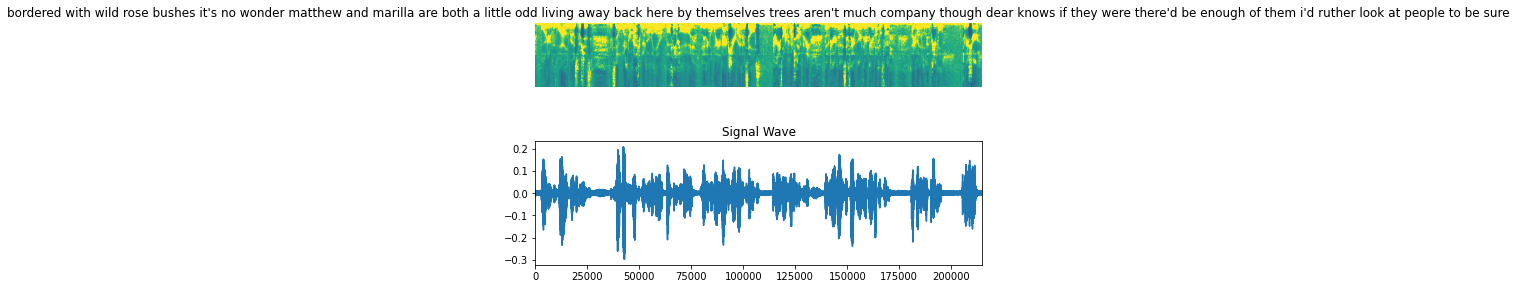

time: 13.3 s (started: 2022-08-30 10:26:53 +00:00)


In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    
    # Wav
    file = tf.io.read_file(list(df_train["key"])[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## Model Building

In [ ]:
# CTC loss to align the audio with chars
def CTCLoss(y_true, y_pred):    
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

time: 11.9 ms (started: 2022-08-30 10:27:06 +00:00)


In [ ]:
fft_length // 2 + 1


193

time: 5.63 ms (started: 2022-08-30 10:27:06 +00:00)


In [ ]:
char_to_num.vocabulary_size()

29

time: 8.14 ms (started: 2022-08-30 10:27:06 +00:00)


time: 19.6 ms (started: 2022-08-30 10:27:06 +00:00)


In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[4, 4],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[4, 4],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Convolution layer 3
    x = layers.Conv2D(
        filters=32,
        kernel_size=[4, 4],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_3",
    )(x)
    x = layers.BatchNormalization(name="conv_3_bn")(x)
    x = layers.ReLU(name="conv_3_relu")(x)

    # Convolution layer 4
    x = layers.Conv2D(
        filters=32,
        kernel_size=[4, 4],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_4",
    )(x)
    x = layers.BatchNormalization(name="conv_4_bn")(x)
    x = layers.ReLU(name="conv_4_relu")(x)

    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="HGS_ASR_model")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

time: 30.6 ms (started: 2022-08-30 10:27:06 +00:00)


In [ ]:
#Model summary
model = build_model(
    input_dim= fft_length // 2 + 1,
    output_dim= char_to_num.vocabulary_size(),
    rnn_units=512,)
model.summary(line_length=110)

Model: "HGS_ASR_model"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        512              
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                    

In [ ]:
# Function to decode the output
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

time: 22.2 ms (started: 2022-08-30 10:27:13 +00:00)


## Training and Evaluating

In [ ]:
# Define the number of epochs.
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs)

Epoch 1/10
9/9 [==============================] - 111s 9s/step - loss: 1051.2773 - val_loss: 1744.8149
Epoch 2/10
9/9 [==============================] - 81s 9s/step - loss: 667.3045 - val_loss: 1444.2063
Epoch 3/10
9/9 [==============================] - 82s 9s/step - loss: 650.7489 - val_loss: 1072.6281
Epoch 4/10
9/9 [==============================] - 81s 9s/step - loss: 644.8444 - val_loss: 894.2366
Epoch 5/10
9/9 [==============================] - 82s 9s/step - loss: 647.9631 - val_loss: 839.2870
Epoch 6/10
9/9 [==============================] - 82s 9s/step - loss: 627.1655 - val_loss: 821.4133
Epoch 7/10
9/9 [==============================] - 81s 9s/step - loss: 618.2037 - val_loss: 811.9509
Epoch 8/10
9/9 [==============================] - 82s 9s/step - loss: 616.9891 - val_loss: 910.6765
Epoch 9/10
9/9 [==============================] - 82s 9s/step - loss: 605.4597 - val_loss: 1156.2769
Epoch 10/10
9/9 [==============================] - 80s 9s/step - loss: 594.5844 - val_loss: 14

## Testing

In [ ]:
predictions = []
targets = []

for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)

print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

print(f"Prediction: {predictions}")

----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : and some of the branches they fastened under water near the dam it was just like putting green things into a refrigerator so they will keep now you see why brownie beaver would no more have thought of building his house on dry land
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : i want a good trusty woman for house service said the stranger as they entered the cabin where walker's slaves were kept here she is and no mistake replied the trader stand up currer my gal here's a gentleman who wishes to see if you will suit him
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the next morning as the passen